<a href="https://colab.research.google.com/github/satoshi0630/AIkadai/blob/master/AI%E3%83%AA%E3%83%86%E3%83%A9%E3%82%B7%E3%83%BC_%E6%AD%A6%E7%94%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# check auth
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'151I4zoMmx8kKONgLZj0sQa3bQCiZeoLx'})

# Download the file to a local disk as 'sample.csv'.
downloaded.GetContentFile('card_data.csv')

import pandas as pd
df = pd.read_csv('card_data.csv',encoding='CP932')
df.head(10) #先頭10行を表示

,Name,Type,Level,Race,Attribute,ATK,DEF
0,Limit Reverse,Trap Card,NaN,Continuous,NaN,NaN,NaN
1,The 13th Grave,Normal Monster,3.0,Zombie,DARK,1200.0,900.0
2,Gem-Enhancement,Trap Card,NaN,Normal,NaN,NaN,NaN
3,Magician's Circle,Trap Card,NaN,Normal,NaN,NaN,NaN
4,Castle of Dark Illusions,Flip Effect Monster,4.0,Fiend,DARK,920.0,1930.0
5,Cipher Spectrum,Trap Card,NaN,Normal,NaN,NaN,NaN
6,Lava Golem,Effect Monster,8.0,Fiend,FIRE,3000.0,2500.0
7,Dark Magic Expanded,Spell Card,NaN,Quick-Play,NaN,NaN,NaN
8,Seismic Crasher,Effect Monster,3.0,Rock,EARTH,1400.0,300.0
9,Laval Lancelord,Effect Monster,6.0,Warrior,FIRE,2100.0,200.0


In [ ]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns



from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import matplotlib as mpl
from sklearn import linear_model

import pickle

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, classification_report

# Jupyter 上で絵を表示するためのマジックコマンド
%matplotlib inline 
import matplotlib.pyplot as plt # matplotlib.pyplot をインポートし、以下 plt と呼ぶ。

In [ ]:
df.head(30).style.bar(subset=['Level','ATK','DEF'])

,Name,Type,Level,Race,Attribute,ATK,DEF
0,Limit Reverse,Trap Card,nan,Continuous,nan,nan,nan
1,The 13th Grave,Normal Monster,3.000000,Zombie,DARK,1200.000000,900.000000
2,Gem-Enhancement,Trap Card,nan,Normal,nan,nan,nan
3,Magician's Circle,Trap Card,nan,Normal,nan,nan,nan
4,Castle of Dark Illusions,Flip Effect Monster,4.000000,Fiend,DARK,920.000000,1930.000000
5,Cipher Spectrum,Trap Card,nan,Normal,nan,nan,nan
6,Lava Golem,Effect Monster,8.000000,Fiend,FIRE,3000.000000,2500.000000
7,Dark Magic Expanded,Spell Card,nan,Quick-Play,nan,nan,nan
8,Seismic Crasher,Effect Monster,3.000000,Rock,EARTH,1400.000000,300.000000
9,Laval Lancelord,Effect Monster,6.000000,Warrior,FIRE,2100.000000,200.000000


In [ ]:
df.describe() # 平均値、標準偏差、最小値、25%四分値、中央値、75%四分値、最大値をまとめて表示

,Level,ATK,DEF
count,4275.000000,4275.000000,4275.000000
mean,4.449591,1455.553216,1212.318129
std,2.185045,899.165365,802.966529
min,1.000000,0.000000,0.000000
25%,3.000000,800.000000,600.000000
50%,4.000000,1500.000000,1200.000000
75%,6.000000,2100.000000,1800.000000
max,12.000000,5000.000000,5000.000000


In [ ]:
df.info() #データの情報を見る

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6534 entries, 0 to 6533
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       6534 non-null   object 
 1   Type       6534 non-null   object 
 2   Level      4275 non-null   float64
 3   Race       6534 non-null   object 
 4   Attribute  4275 non-null   object 
 5   ATK        4275 non-null   float64
 6   DEF        4275 non-null   float64
dtypes: float64(3), object(4)
memory usage: 357.5+ KB


In [ ]:
df.isnull().sum()

Name            0
Type            0
Level        2259
Race            0
Attribute    2259
ATK          2259
DEF          2259
dtype: int64

In [ ]:
np.set_printoptions(threshold=np.inf)
np.column_stack(df) #列名を全て取得

array([['Name', 'Type', 'Level', 'Race', 'Attribute', 'ATK', 'DEF']],
      dtype='<U9')

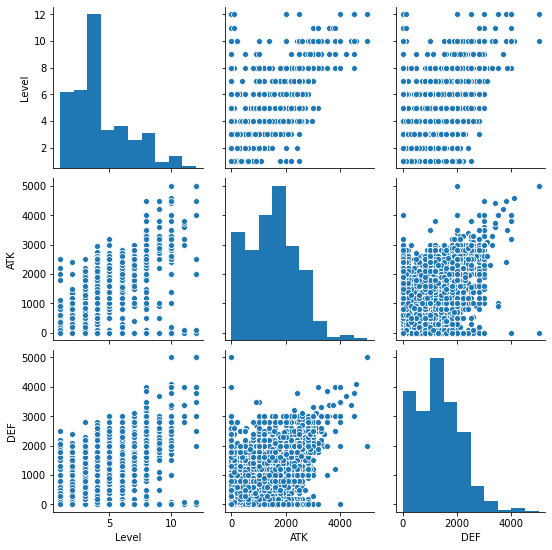

In [ ]:
pg = sns.pairplot(df.iloc[:,[2,5,6]])

In [ ]:
corr_mat = df.iloc[:,[2,5,6]].corr(method='pearson')
# method='spearman'でスピアマン、'kendall'でケンドールも指定可能
corr_mat

,Level,ATK,DEF
Level,1.000000,0.725354,0.592225
ATK,0.725354,1.000000,0.508246
DEF,0.592225,0.508246,1.000000


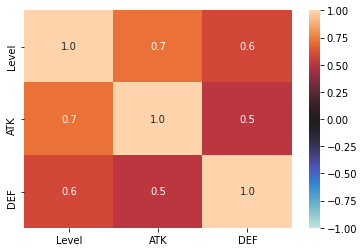

In [ ]:
#ヒートマップ化

sns.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show() 

In [ ]:
df_monster = df.dropna()
df_monster.head(10)

,Name,Type,Level,Race,Attribute,ATK,DEF
1,The 13th Grave,Normal Monster,3.0,Zombie,DARK,1200.0,900.0
4,Castle of Dark Illusions,Flip Effect Monster,4.0,Fiend,DARK,920.0,1930.0
6,Lava Golem,Effect Monster,8.0,Fiend,FIRE,3000.0,2500.0
8,Seismic Crasher,Effect Monster,3.0,Rock,EARTH,1400.0,300.0
9,Laval Lancelord,Effect Monster,6.0,Warrior,FIRE,2100.0,200.0
11,Performapal Springoose,Effect Monster,5.0,Winged Beast,WIND,1100.0,2400.0
12,Miracle Flipper,Effect Monster,2.0,Spellcaster,LIGHT,300.0,500.0
13,Key Mouse,Tuner Monster,1.0,Beast,EARTH,100.0,100.0
15,Vylon Hept,Effect Monster,4.0,Fairy,LIGHT,1800.0,800.0
16,Koa'ki Meiru Prototype,Effect Monster,4.0,Rock,EARTH,1800.0,1800.0


In [ ]:
df_monster.astype('str').describe()

,Name,Type,Level,Race,Attribute,ATK,DEF
count,4275,4275,4275,4275,4275,4275,4275
unique,4215,21,12,24,7,77,70
top,Dark Magician,Effect Monster,4.0,Warrior,DARK,0.0,1000.0
freq,9,2494,1384,596,1117,292,447


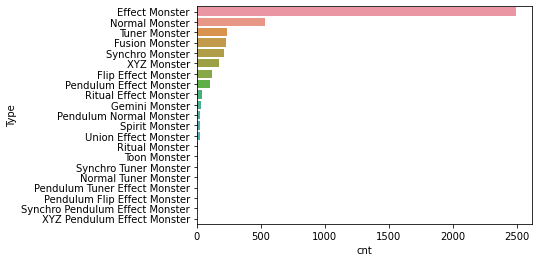

In [ ]:
Type1 = pd.DataFrame(df_monster["Type"])
Type2 = pd.DataFrame(Type1["Type"].value_counts())
Type3 = Type2.reset_index()
Type4 = Type3.sort_values("index")
Type5 = Type4.rename(columns={"index":"Type","Type":"cnt"})
Type6 = Type5.sort_values(by="cnt",ascending=False)
sns.barplot(x="cnt",y="Type",data =Type6)

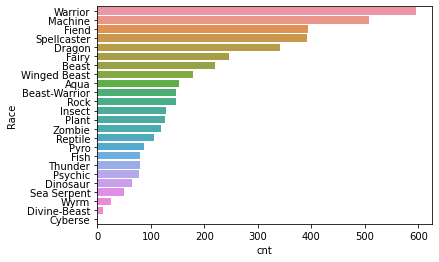

In [ ]:
Race1 = pd.DataFrame(df_monster["Race"])
Race2 = pd.DataFrame(Race1["Race"].value_counts())
Race3 = Race2.reset_index()
Race4 = Race3.sort_values("index")
Race5 = Race4.rename(columns={"index":"Race","Race":"cnt"})
Race6 = Race5.sort_values(by="cnt",ascending=False)
sns.barplot(x="cnt",y="Race",data =Race6)

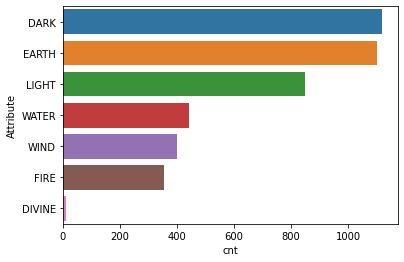

In [ ]:
Attribute1 = pd.DataFrame(df_monster["Attribute"])

Attribute2 = pd.DataFrame(Attribute1["Attribute"].value_counts())
Attribute3 = Attribute2.reset_index()
Attribute4 = Attribute3.sort_values("index")
Attribute5 = Attribute4.rename(columns={"index":"Attribute","Attribute":"cnt"})
Attribute6 = Attribute5.sort_values(by="cnt",ascending=False)
sns.barplot(x="cnt",y="Attribute",data =Attribute6)


In [ ]:
df_monster.head()

,Name,Type,Level,Race,Attribute,ATK,DEF
1,The 13th Grave,Normal Monster,3.0,Zombie,DARK,1200.0,900.0
4,Castle of Dark Illusions,Flip Effect Monster,4.0,Fiend,DARK,920.0,1930.0
6,Lava Golem,Effect Monster,8.0,Fiend,FIRE,3000.0,2500.0
8,Seismic Crasher,Effect Monster,3.0,Rock,EARTH,1400.0,300.0
9,Laval Lancelord,Effect Monster,6.0,Warrior,FIRE,2100.0,200.0


In [ ]:
Attributes = list(set(list(df_monster['Attribute'])))
print(len(Attributes), type)

7 <class 'type'>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
